# MediaPipe로 랜드마크 추출

- 총 12개의 랜드마크 추출.
- 데이터셋은 모두 10초 영상으로 구성됨.
- 이를 프레임 변환하면 모두 300 프레임으로 형성됨
- 따라서 영상 전처리 시, 한 영상 당 (300, 12, 3) 의 벡터 형성


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os
import glob # 파일 목록을 가져오기 위해 추가

# --- 설정 ---
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# 저장할 랜드마크 인덱스 리스트 정의
# 11:L_SHOULDER, 12:R_SHOULDER, 23:L_HIP, 24:R_HIP, 25:L_KNEE, 26:R_KNEE,
# 27:L_ANKLE, 28:R_ANKLE, 29:L_HEEL, 30:R_HEEL, 31:L_FOOT_INDEX, 32:R_FOOT_INDEX
landmark_indices_to_save = [11, 12, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
num_selected_landmarks = len(landmark_indices_to_save) # 저장할 랜드마크 개수 (12개)

# 비디오 파일이 있는 디렉토리 경로 *** 수정된 부분 ***
input_video_dir = './../data/Video_Dataset/good' # 예시: 비디오들이 있는 폴더

# 처리할 비디오 파일 확장자 목록 *** 추가된 부분 ***
# 필요에 따라 '.avi', '.mov' 등을 추가하세요.
allowed_extensions = ('.mp4', '.avi', '.mov', '.mkv')
# 결과를 저장할 디렉토리 경로
# output_dir = './../data/mediapipe_res/'
output_dir = './../data/mediapipe_res/good'

# 화면 표시용 창 크기 조절 비율 (0.5 = 50%) - 주석 처리 (필요시 해제)
# display_scale = 0.5

# --- MediaPipe Pose 객체 생성 (한 번만 생성) ---
pose = None # 초기화
try:
    pose = mp_pose.Pose(
        static_image_mode=False,
        model_complexity=1,
        enable_segmentation=False,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5)
    print("MediaPipe Pose 객체 생성 성공.")
except Exception as e:
    print(f"MediaPipe Pose 객체 생성 중 오류 발생: {e}")
    exit() # Pose 객체 생성 실패 시 종료

# --- 저장 디렉토리 생성 (한 번만 실행) ---
os.makedirs(output_dir, exist_ok=True)
print(f"결과 저장 디렉토리: {output_dir}")

# --- 지정된 디렉토리의 모든 비디오 파일 처리 --- *** 수정된 부분 ***

# input_video_dir 내의 모든 파일을 검색
all_files = os.listdir(input_video_dir)
video_files = [f for f in all_files if os.path.isfile(os.path.join(input_video_dir, f)) and f.lower().endswith(allowed_extensions)]

print(f"\n총 {len(video_files)}개의 비디오 파일을 처리합니다: {video_files}")

if not video_files:
    print(f"오류: '{input_video_dir}' 디렉토리에서 비디오 파일을 찾을 수 없습니다.")
    # pose 객체가 생성되었는지 확인 후 닫기 (오류 방지)
    if pose:
        try:
            pose.close()
            print("MediaPipe Pose 객체를 닫았습니다 (비디오 없음).")
        except Exception as e:
             print(f"MediaPipe Pose 객체를 닫는 중 오류 발생 (비디오 없음): {e}")
    exit()

# 각 비디오 파일에 대해 루프 실행
for video_filename in video_files:
    video_path = os.path.join(input_video_dir, video_filename)
    print(f"\n--- 비디오 처리 시작: {video_path} ---")

    # --- 비디오 처리 및 데이터 저장 (각 비디오별로 실행) ---
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"오류: 비디오 파일을 열 수 없습니다 -> {video_path}. 다음 파일로 건너<0xEB><0x9B><0x84>니다.")
        continue # 다음 비디오 파일로 넘어감

    all_frame_landmarks = []
    frame_count = 0
    print(f"'{video_filename}' 처리 중... (선택된 {num_selected_landmarks}개 랜드마크 저장)")

    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print(f"'{video_filename}' 처리 완료 (총 {frame_count} 프레임) 또는 프레임 읽기 실패.")
            break

        frame_count += 1
        # 원본 이미지 크기는 필요시 사용 (화면 표시 등)
        # original_height, original_width = image.shape[:2]

        # MediaPipe 처리
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 성능 향상을 위해 이미지를 쓰기 불가로 전환 (선택 사항)
        image_rgb.flags.writeable = False
        results = pose.process(image_rgb)
        # 이미지 다시 쓰기 가능하게 전환
        image_rgb.flags.writeable = True
        # annotated_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR) # 시각화 시 필요

        # 현재 프레임의 *선택된* 랜드마크 데이터를 저장할 NumPy 배열
        # 크기: (num_selected_landmarks, 3), 기본값은 NaN
        frame_landmarks_np = np.full((num_selected_landmarks, 3), np.nan, dtype=np.float32)

        if results.pose_world_landmarks:
            landmarks = results.pose_world_landmarks.landmark
            # 지정된 인덱스의 랜드마크 좌표만 추출하여 배열 생성
            try:
                 # 리스트 컴프리헨션을 사용하여 선택된 인덱스의 좌표만 추출
                 selected_coords = [
                     [landmarks[i].x, landmarks[i].y, landmarks[i].z]
                     for i in landmark_indices_to_save
                 ]
                 # 좌표값이 유효한지 확인 (가끔 비정상적인 값이 들어올 수 있음)
                 if all(-1e6 < coord < 1e6 for point in selected_coords for coord in point):
                    frame_landmarks_np = np.array(selected_coords, dtype=np.float32)
                 else:
                    print(f"프레임 {frame_count} ({video_filename}): 비정상적인 랜드마크 좌표 감지. NaN으로 처리.")
                    # frame_landmarks_np는 이미 NaN으로 초기화되어 있음

            except IndexError:
                 print(f"프레임 {frame_count} ({video_filename}): 랜드마크 인덱스 접근 오류 발생. NaN으로 처리.")
                 # frame_landmarks_np는 이미 NaN으로 초기화되어 있음
            except Exception as e:
                 print(f"프레임 {frame_count} ({video_filename}): 랜드마크 처리 중 오류 발생: {e}. NaN으로 처리.")

            # (선택 사항) 시각화 - 주석 처리
            # if results.pose_landmarks:
            #     mp_drawing.draw_landmarks(
            #         annotated_image,
            #         results.pose_landmarks, # 여기는 여전히 모든 랜드마크 표시
            #         mp_pose.POSE_CONNECTIONS,
            #         landmark_drawing_spec=mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
            #         connection_drawing_spec=mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
            #     )

        # 현재 프레임의 *선택된* 랜드마크 배열을 전체 리스트에 추가
        all_frame_landmarks.append(frame_landmarks_np)

        # (선택 사항) 리사이즈 및 화면 표시 - 주석 처리
        # new_width = int(original_width * display_scale)
        # new_height = int(original_height * display_scale)
        # resized_image = cv2.resize(annotated_image, (new_width, new_height), interpolation=cv2.INTER_AREA)
        # cv2.imshow(f'MediaPipe Pose - {video_filename}', resized_image)
        # if cv2.waitKey(5) & 0xFF == ord('q'):
        #     print("사용자 요청으로 처리 중단.")
        #     break # 내부 루프 중단

    # --- 한 비디오 루프 종료 후 데이터 저장 ---
    cap.release() # 현재 비디오 파일 닫기
    # cv2.destroyAllWindows() # 각 비디오마다 창을 닫으려면 여기, 모든 처리 후 닫으려면 밖으로 이동

    if all_frame_landmarks:
        # 리스트를 하나의 큰 3D NumPy 배열로 결합
        # 최종 형태: (총 프레임 수, num_selected_landmarks, 3) -> 예: (183, 12, 3)
        try:
            landmark_data_np = np.array(all_frame_landmarks)
            print(f"'{video_filename}' 최종 데이터 형태: {landmark_data_np.shape}")

            # 저장 파일명 생성 (원본 비디오 파일명 기반)
            base_filename = os.path.splitext(video_filename)[0]
            output_filename = f"{base_filename}_res.npy"
            output_filepath = os.path.join(output_dir, output_filename)

            # NumPy 배열 저장
            np.save(output_filepath, landmark_data_np)
            print(f"선택된 랜드마크 데이터 저장 완료: {output_filepath}")

        except ValueError as ve:
             print(f"'{video_filename}' 데이터 배열 변환 중 오류 발생: {ve}. 프레임별 랜드마크 개수가 다를 수 있습니다. 건너<0xEB><0x9B><0x84>니다.")
        except Exception as e:
            print(f"'{output_filepath}' 파일 저장 또는 데이터 처리 중 오류 발생: {e}")

    else:
        print(f"'{video_filename}'에서 저장할 랜드마크 데이터가 없습니다.")

    # 'q' 키로 중단된 경우 외부 루프도 중단 (필요시 주석 해제)
    # if cv2.waitKey(1) & 0xFF == ord('q'): # waitKey(5) 루프 안에 있을 때만 유효
    #     break

# --- 모든 비디오 처리 완료 후 ---
# cv2.destroyAllWindows() # 모든 창 닫기 (주석처리 되어있음)

# MediaPipe Pose 객체 닫기 (객체가 유효할 때만) *** 수정된 부분 ***
if pose:
    try:
        pose.close()
        print("\nMediaPipe Pose 객체를 성공적으로 닫았습니다.")
    except Exception as e:
        print(f"\nMediaPipe Pose 객체를 닫는 중 오류 발생: {e}")
else:
    print("\nMediaPipe Pose 객체가 유효하지 않아 닫기를 건너<0xEB><0x9B><0x84>니다.")


print("\n모든 비디오 파일 처리 완료.")


I0000 00:00:1746543973.471201 1621901 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1746543973.489425 1641571 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.01), renderer: NVIDIA GeForce RTX 4090/PCIe/SSE2
W0000 00:00:1746543973.565510 1641520 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746543973.609534 1641535 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


MediaPipe Pose 객체 생성 성공.
결과 저장 디렉토리: ./../data/mediapipe_res/bad_innner_thigh

총 235개의 비디오 파일을 처리합니다: ['0918_squat_000029.mp4', '0918_squat_000030.mp4', '0918_squat_000032.mp4', '0918_squat_000033.mp4', '0918_squat_000036.mp4', '0918_squat_000066.mp4', '0918_squat_000069.mp4', '0918_squat_000070.mp4', '0918_squat_000073.mp4', '0922_squat_000040.mp4', '0922_squat_000041.mp4', '0922_squat_000043.mp4', '0922_squat_000044.mp4', '0922_squat_000047.mp4', '0922_squat_000081.mp4', '0922_squat_000082.mp4', '0922_squat_000084.mp4', '0922_squat_000085.mp4', '0922_squat_000086.mp4', '0922_squat_000088.mp4', '0922_squat_000139.mp4', '0922_squat_000140.mp4', '0922_squat_000141.mp4', '0922_squat_000144.mp4', '0922_squat_000180.mp4', '0922_squat_000181.mp4', '0922_squat_000182.mp4', '0922_squat_000184.mp4', '0922_squat_000185.mp4', '0926_squat_000042.mp4', '0926_squat_000043.mp4', '0926_squat_000049.mp4', '0926_squat_000050.mp4', '0926_squat_000144.mp4', '0926_squat_000147.mp4', '0926_squat_000151.mp4

KeyboardInterrupt: 

# npy파일 읽어오기 (임시)

In [ ]:
import numpy as np
import os

# 저장된 파일 경로 (위 코드에서 저장한 경로와 동일해야 함)
output_dir = './../data/mediapipe_res/'
video_basename = 'squat' # 예시 원본 파일명 (확장자 제외)
filename = f"{video_basename}_res.npy"
filepath = os.path.join(output_dir, filename)

# .npy 파일 로드
try:
    loaded_landmarks = np.load(filepath)
    print(f"파일 로드 성공: {filepath}")
    print(f"로드된 데이터 형태: {loaded_landmarks.shape}") # 예: (183, 12, 3)

    print(loaded_landmarks)
    # # 로드된 데이터 확인
    # # 첫 번째 프레임의 첫 번째 저장된 랜드마크(LEFT_SHOULDER, 원래 인덱스 11) 좌표
    # if loaded_landmarks.shape[0] > 0:
    #     print("\n첫 번째 프레임 데이터 예시 (일부):")
    #     # 저장된 배열의 0번 인덱스 = 원래 11번(LEFT_SHOULDER)
    #     print(f"  프레임 0, 저장된 0번 랜드마크(원래 11번): {loaded_landmarks[0, 0, :]}")
    #     # 저장된 배열의 2번 인덱스 = 원래 23번(LEFT_HIP)
    #     print(f"  프레임 0, 저장된 2번 랜드마크(원래 23번): {loaded_landmarks[0, 2, :]}")

except FileNotFoundError:
    print(f"오류: 파일을 찾을 수 없습니다 -> {filepath}")
except Exception as e:
    print(f"파일 로드 중 오류 발생: {e}")
    


파일 로드 성공: ./../data/mediapipe_res/squat_res.npy
로드된 데이터 형태: (183, 12, 3)
[[[-0.15581077 -0.46270552 -0.04443497]
  [ 0.16361548 -0.46307558 -0.0032042 ]
  [-0.08693165 -0.00426618  0.00285172]
  ...
  [ 0.25140098  0.7802632   0.05736061]
  [-0.22107351  0.7339341   0.03744415]
  [ 0.2957428   0.7685144   0.0658367 ]]

 [[-0.1557893  -0.46018198 -0.06593481]
  [ 0.16423976 -0.46305236 -0.023705  ]
  [-0.08739546 -0.0035474   0.0046195 ]
  ...
  [ 0.24797574  0.770414    0.12350331]
  [-0.23832434  0.7117693   0.11575799]
  [ 0.29508886  0.75143105  0.13343483]]

 [[-0.15676185 -0.45699316 -0.05936539]
  [ 0.16465895 -0.45922515 -0.01701877]
  [-0.08946616 -0.00330456  0.00541176]
  ...
  [ 0.24844845  0.7410742   0.14707631]
  [-0.2383831   0.69079995  0.15047199]
  [ 0.2950963   0.7245745   0.16787218]]

 ...

 [[-0.1363099  -0.4344412  -0.05622086]
  [ 0.18938147 -0.41922623 -0.03813142]
  [-0.1027734  -0.00108946  0.01134231]
  ...
  [ 0.2814197   0.2612016   0.3966929 ]
  [-0.29609

# 파생 Feature 생성 (10개)

- **관절 각도:**
    1. **왼쪽 무릎 각도 (Left Knee Angle):** 왼쪽 엉덩이-왼쪽 무릎-왼쪽 발목 사이의 각도
    2. **오른쪽 무릎 각도 (Right Knee Angle):** 오른쪽 엉덩이-오른쪽 무릎-오른쪽 발목 사이의 각도
    3. **왼쪽 고관절 각도 (Left Hip Angle):** 왼쪽 어깨-왼쪽 엉덩이-왼쪽 무릎 사이의 각도
    4. **오른쪽 고관절 각도 (Right Hip Angle):** 오른쪽 어깨-오른쪽 엉덩이-오른쪽 무릎 사이의 각도
    5. **왼쪽 발목 각도 (Left Ankle Angle):** 왼쪽 무릎-왼쪽 발목-왼쪽 발끝 사이의 각도
    6. **오른쪽 발목 각도 (Right Ankle Angle):** 오른쪽 무릎-오른쪽 발목-오른쪽 발끝 사이의 각도
    7. **상체 기울기 (Torso Angle):** 엉덩이 중앙과 어깨 중앙을 잇는 선이 수직선(Y축)과 이루는 각도. (앞으로 얼마나 숙였는지)

- **상대적 위치/거리:**

    8. **엉덩이 높이 (Hip Height):** 발목(또는 발뒤꿈치) 중앙으로부터 엉덩이 중앙까지의 수직(Y) 거리. (스쿼트 깊이)
    9. **무릎 간 거리 (Knee Distance):** 왼쪽 무릎과 오른쪽 무릎 사이의 수평 거리. (무릎 모임 등 확인)
    10. **발목 간 거리 (Ankle Distance / Stance Width):** 왼쪽 발목과 오른쪽 발목 사이의 수평 거리. (스탠스 너비)

In [ ]:
import numpy as np
import os

def calculate_angle(a, b, c):
    """세 점 a, b, c가 주어졌을 때 점 b에서의 각도를 계산 (단위: 도)"""
    a = np.array(a)  # 첫 번째 점
    b = np.array(b)  # 중간 점 (각도의 꼭짓점)
    c = np.array(c)  # 세 번째 점

    # 벡터 BA, BC 계산
    ba = a - b
    bc = c - b

    # 코사인 각도 계산
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))

    # np.arccos 입력값은 [-1, 1] 범위여야 함 (부동소수점 오류 방지)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))

    return np.degrees(angle)

def extract_derived_features(landmarks_frame):
    """
    한 프레임의 선택된 랜드마크 (12, 3) 배열로부터 파생 특징을 계산
    """
    features = []

    # 입력 랜드마크 배열에서 각 부위 좌표 할당
    try:
        l_shoulder = landmarks_frame[0]
        r_shoulder = landmarks_frame[1]
        l_hip = landmarks_frame[2]
        r_hip = landmarks_frame[3]
        l_knee = landmarks_frame[4]
        r_knee = landmarks_frame[5]
        l_ankle = landmarks_frame[6]
        r_ankle = landmarks_frame[7]
        # l_heel = landmarks_frame[8] # 필요시 사용
        # r_heel = landmarks_frame[9] # 필요시 사용
        l_foot_index = landmarks_frame[10]
        r_foot_index = landmarks_frame[11]

        # 모든 입력 랜드마크가 유효한지 (NaN이 아닌지) 확인
        if np.isnan(landmarks_frame).any():
            # 랜드마크 중 하나라도 NaN이면 10개의 NaN 특징 반환
            return np.full(10, np.nan, dtype=np.float32)

        # 1. 왼쪽 무릎 각도
        left_knee_angle = calculate_angle(l_hip, l_knee, l_ankle)
        features.append(left_knee_angle)

        # 2. 오른쪽 무릎 각도
        right_knee_angle = calculate_angle(r_hip, r_knee, r_ankle)
        features.append(right_knee_angle)

        # 3. 왼쪽 고관절 각도
        left_hip_angle = calculate_angle(l_shoulder, l_hip, l_knee)
        features.append(left_hip_angle)

        # 4. 오른쪽 고관절 각도
        right_hip_angle = calculate_angle(r_shoulder, r_hip, r_knee)
        features.append(right_hip_angle)

        # 5. 왼쪽 발목 각도
        left_ankle_angle = calculate_angle(l_knee, l_ankle, l_foot_index)
        features.append(left_ankle_angle)

        # 6. 오른쪽 발목 각도
        right_ankle_angle = calculate_angle(r_knee, r_ankle, r_foot_index)
        features.append(right_ankle_angle)

        # 7. 상체 기울기 (엉덩이 중앙-어깨 중앙 벡터와 수직선(Y축) 사이의 각도)
        mid_shoulder = (l_shoulder + r_shoulder) / 2
        mid_hip = (l_hip + r_hip) / 2
        torso_vector = mid_shoulder - mid_hip # 엉덩이 -> 어깨 방향 벡터
        
        # Y축 방향 벡터 (0,1,0) - MediaPipe 월드 좌표계 기준 Y축이 위쪽
        # 만약 Y축이 아래쪽을 향한다면 (0,-1,0) 또는 각도 계산 후 보정 필요
        vertical_vector = np.array([0, 1, 0]) 
        
        # torso_vector가 거의 0벡터이거나 vertical_vector가 0벡터일 가능성은 낮으나 안전하게 처리
        norm_torso = np.linalg.norm(torso_vector)
        norm_vertical = np.linalg.norm(vertical_vector) # 항상 1

        if norm_torso > 1e-6 : # 매우 작은 벡터는 각도 계산 무의미
            cosine_torso_vertical = np.dot(torso_vector, vertical_vector) / (norm_torso * norm_vertical)
            torso_angle = np.degrees(np.arccos(np.clip(cosine_torso_vertical, -1.0, 1.0)))
        else:
            torso_angle = np.nan # 또는 90도 등 적절한 값
        features.append(torso_angle) # 0도에 가까울수록 상체가 수직으로 선 상태

        # 8. 엉덩이 높이 (발목 중앙 기준 Y좌표 차이)
        mid_ankle = (l_ankle + r_ankle) / 2
        hip_height = mid_hip[1] - mid_ankle[1] # Y 좌표 차이
        features.append(hip_height)

        # 9. 무릎 간 거리 (X, Z 평면에서의 거리)
        knee_diff_vector = l_knee - r_knee
        knee_distance = np.linalg.norm(np.array([knee_diff_vector[0], knee_diff_vector[2]])) # X, Z 성분만 사용
        features.append(knee_distance)

        # 10. 발목 간 거리 (스탠스 너비, X, Z 평면에서의 거리)
        ankle_diff_vector = l_ankle - r_ankle
        ankle_distance = np.linalg.norm(np.array([ankle_diff_vector[0], ankle_diff_vector[2]])) # X, Z 성분만 사용
        features.append(ankle_distance)

    except Exception as e:
        # print(f"특징 계산 중 오류: {e}")
        # 오류 발생 시 NaN으로 채워진 특징 배열 반환
        return np.full(10, np.nan, dtype=np.float32)
        
    return np.array(features, dtype=np.float32)


# --- 사용 예시 ---
if __name__ == '__main__':
    # 예시: 하나의 .npy 파일 로드 (실제 경로로 변경 필요)
    data_dir = './data/mediapipe_res/'
    video_filename = '0918_squat_000001_res.npy' # 이전 코드에서 저장한 파일명 예시
    full_path = os.path.join(data_dir, video_filename)

    if not os.path.exists(full_path):
        print(f"오류: 예시 데이터 파일({full_path})을 찾을 수 없습니다. ")
        print("먼저 랜드마크 저장 코드를 실행하여 .npy 파일을 생성해주세요.")
        # 임시 더미 데이터 생성으로 테스트 계속 진행
        print("임시 더미 데이터로 특징 추출 테스트를 진행합니다.")
        video_landmarks_data = np.random.rand(300, 12, 3).astype(np.float32) # (프레임, 랜드마크, 좌표)
    else:
        video_landmarks_data = np.load(full_path) # (300, 12, 3) 형태

    print(f"로드된 랜드마크 데이터 형태: {video_landmarks_data.shape}")

    all_frames_derived_features = []
    for frame_idx in range(video_landmarks_data.shape[0]):
        landmarks_one_frame = video_landmarks_data[frame_idx, :, :] # (12, 3)
        
        # 현재 프레임의 랜드마크가 모두 NaN인지 확인 (랜드마크 감지 실패 프레임)
        if np.isnan(landmarks_one_frame).all():
            derived_features = np.full(10, np.nan, dtype=np.float32) # 특징 개수에 맞게 NaN 배열 생성
            # print(f"프레임 {frame_idx}: 랜드마크 데이터가 없어 특징을 NaN으로 처리합니다.")
        else:
            derived_features = extract_derived_features(landmarks_one_frame)
            # print(f"프레임 {frame_idx} 특징: {derived_features}")
        
        all_frames_derived_features.append(derived_features)

    # 리스트를 NumPy 배열로 변환 (최종 형태: [총 프레임 수, 파생 특징 수])
    derived_features_np = np.array(all_frames_derived_features)
    print(f"\n최종 파생 특징 데이터 형태: {derived_features_np.shape}") # 예: (300, 10)
    
    # NaN 값 개수 확인 (선택 사항)
    nan_count = np.isnan(derived_features_np).sum()
    if nan_count > 0:
        print(f"파생 특징 데이터에 총 {nan_count}개의 NaN 값이 포함되어 있습니다.")
        # NaN 값 처리 방법 고려 필요 (예: 평균값 대체, 해당 윈도우 제외 등)

    # 이제 이 derived_features_np 배열을 가지고 시퀀스 윈도우를 만들고
    # LSTM Autoencoder 학습 데이터로 사용할 수 있습니다.
    # (예: (300,10) -> 여러 개의 (30,10) 윈도우로 변환)

오류: 예시 데이터 파일(./data/mediapipe_res/0918_squat_000001_res.npy)을 찾을 수 없습니다. 
먼저 랜드마크 저장 코드를 실행하여 .npy 파일을 생성해주세요.
임시 더미 데이터로 특징 추출 테스트를 진행합니다.
로드된 랜드마크 데이터 형태: (300, 12, 3)

최종 파생 특징 데이터 형태: (300, 10)
[[112.084526    31.780703   116.0378     ...   0.36453608   0.81620485
    0.9974435 ]
 [ 79.33784     45.571724    97.18631    ...   0.52613163   0.83155316
    0.35017005]
 [ 52.423473    29.941498    63.05344    ...   0.23798396   0.6449251
    1.0046434 ]
 ...
 [ 87.97786     60.82125     78.70274    ...   0.15367049   0.82493156
    0.66171145]
 [ 93.20865     34.481865    55.538914   ...   0.2849288    0.18677577
    0.13462302]
 [ 22.758097    13.43904     50.10211    ...   0.1245476    0.73259896
    0.83435   ]]


# Model Train

- Model : Lstm Autoencoder

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import os
import glob
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm


In [72]:
# --- 0. 파생 특징 계산  ---
def calculate_angle(a, b, c):
    """세 점 a, b, c가 주어졌을 때 점 b에서의 각도를 계산 (단위: 도)"""
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6) # 분모 0 방지
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

def extract_derived_features(landmarks_frame):
    """한 프레임의 선택된 랜드마크 (12, 3) 배열로부터 파생 특징을 계산"""
    features = []
    try:
        l_shoulder, r_shoulder, l_hip, r_hip, l_knee, r_knee, \
        l_ankle, r_ankle, _, _, l_foot_index, r_foot_index = landmarks_frame

        if np.isnan(landmarks_frame).any():
            return np.full(10, np.nan, dtype=np.float32)

        features.append(calculate_angle(l_hip, l_knee, l_ankle))
        features.append(calculate_angle(r_hip, r_knee, r_ankle))
        features.append(calculate_angle(l_shoulder, l_hip, l_knee))
        features.append(calculate_angle(r_shoulder, r_hip, r_knee))
        features.append(calculate_angle(l_knee, l_ankle, l_foot_index))
        features.append(calculate_angle(r_knee, r_ankle, r_foot_index))

        mid_shoulder = (l_shoulder + r_shoulder) / 2
        mid_hip = (l_hip + r_hip) / 2
        torso_vector = mid_shoulder - mid_hip
        vertical_vector = np.array([0, 1, 0])
        norm_torso = np.linalg.norm(torso_vector)
        if norm_torso > 1e-6:
            cosine_torso_vertical = np.dot(torso_vector, vertical_vector) / norm_torso
            features.append(np.degrees(np.arccos(np.clip(cosine_torso_vertical, -1.0, 1.0))))
        else:
            features.append(np.nan)

        mid_ankle = (l_ankle + r_ankle) / 2
        features.append(mid_hip[1] - mid_ankle[1]) # Y좌표 기준 엉덩이 높이

        knee_diff_vector = l_knee - r_knee
        features.append(np.linalg.norm(np.array([knee_diff_vector[0], knee_diff_vector[2]])))

        ankle_diff_vector = l_ankle - r_ankle
        features.append(np.linalg.norm(np.array([ankle_diff_vector[0], ankle_diff_vector[2]])))
    except Exception:
        return np.full(10, np.nan, dtype=np.float32)
    return np.array(features, dtype=np.float32)

In [ ]:
# --- 1. 하이퍼파라미터 및 설정 ---
DATA_DIR = "./../data/mediapipe_res/good" # .npy 파일들이 있는 디렉토리
TIME_STEPS = 30          # 윈도우 크기 (입력 시퀀스 길이)
N_DERIVED_FEATURES = 10  # extract_derived_features 함수가 반환하는 특징 개수
LATENT_DIM = 8           # 잠재 공간 차원
HIDDEN_DEC_DIM = 64      # 디코더 LSTM의 은닉 차원
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NUM_EPOCHS = 50 # 예시, 실제로는 더 많이 필요할 수 있음
WINDOW_STRIDE = 1 # 슬라이딩 윈도우 간격

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [91]:
# --- 2. 데이터 로딩 및 전처리 ---
def load_and_preprocess_data(data_dir, feature_extraction_fn, time_steps, stride):
    all_sequences = []
    npy_files = glob.glob(os.path.join(data_dir, "*.npy"))
    if not npy_files:
        print(f"경고: {data_dir} 에서 .npy 파일을 찾을 수 없습니다.")
        return np.array([]), None

    for npy_file in tqdm(npy_files, leave=False, desc="processing data"):
        try:
            landmarks_video = np.load(npy_file) # (300, 12, 3)
            if landmarks_video.ndim != 3 or landmarks_video.shape[1] != 12 or landmarks_video.shape[2] != 3:
                print(f"경고: {npy_file} 파일의 형태가 올바르지 않습니다 ({landmarks_video.shape}). ")
                continue
            
            derived_features_video = []
            for frame_idx in range(landmarks_video.shape[0]):
                landmarks_frame = landmarks_video[frame_idx, :, :]
                derived_features = feature_extraction_fn(landmarks_frame)
                derived_features_video.append(derived_features)
            
            derived_features_video = np.array(derived_features_video) # (300, N_DERIVED_FEATURES)

            # 슬라이딩 윈도우 생성
            for i in range(0, derived_features_video.shape[0] - time_steps + 1, stride):
                sequence = derived_features_video[i : i + time_steps]
                all_sequences.append(sequence)
        except Exception as e:
            print(f"{npy_file} 처리 중 오류 발생: {e}")

    if not all_sequences:
        print("처리할 시퀀스가 없습니다.")
        return np.array([]), None
        
    all_sequences_np = np.array(all_sequences, dtype=np.float32) # (num_windows, time_steps, n_derived_features)
    
    # NaN 값을 포함하는 윈도우 제거
    nan_mask = ~np.isnan(all_sequences_np).any(axis=(1, 2))
    all_sequences_np = all_sequences_np[nan_mask]
    print(f"NaN 포함 윈도우 제거 후 총 윈도우 수: {all_sequences_np.shape[0]}")

    if all_sequences_np.shape[0] == 0:
        print("NaN 제거 후 남은 윈도우가 없습니다.")
        return np.array([]), None

    # 데이터 정규화 (StandardScaler)
    # 스케일러는 학습 데이터에만 fit하고, 전체 데이터에 transform 적용
    # 여기서는 전체 데이터를 한번에 로드했으므로, 분할 후 스케일링 필요.
    # 혹은 모든 정상 데이터로 스케일러를 학습시킬 수도 있음 (오토인코더의 경우)
    # 여기서는 편의상 전체에 대해 한번에 하지만, 엄밀하게는 train/val 분리 후 train으로 fit해야 함.
    
    # scaler를 반환하기 위해 일단 여기서는 fit/transform 하지 않고, 데이터를 반환
    return all_sequences_np

# 데이터 로드
raw_windows = load_and_preprocess_data(DATA_DIR, extract_derived_features, TIME_STEPS, WINDOW_STRIDE)

# if raw_windows.shape[0] < 2 : # 학습/검증 분할을 위해 최소 2개 필요
#     print("학습을 위한 데이터가 부족합니다. 프로그램을 종료합니다.")
#     exit()

# 학습/검증 데이터 분할 (예: 80% 학습, 20% 검증)
train_size = int(0.8 * len(raw_windows))
val_size = len(raw_windows) - train_size
train_data, val_data = random_split(raw_windows, [train_size, val_size])

# 정규화
# StandardScaler는 2D 데이터를 기대하므로 reshape 필요
scaler = StandardScaler()
# train_data를 2D로 변환하여 scaler 학습
n_samples_train, ts_train, n_features_train = train_data.dataset[train_data.indices].shape # PyTorch Subset의 실제 데이터 접근
train_data_reshaped = train_data.dataset[train_data.indices].reshape(-1, n_features_train)
scaler.fit(train_data_reshaped)

# 학습 데이터 정규화
train_data_scaled_reshaped = scaler.transform(train_data_reshaped)
train_sequences = train_data_scaled_reshaped.reshape(n_samples_train, ts_train, n_features_train)

# 검증 데이터 정규화
n_samples_val, ts_val, n_features_val = val_data.dataset[val_data.indices].shape
val_data_reshaped = val_data.dataset[val_data.indices].reshape(-1, n_features_val)
val_data_scaled_reshaped = scaler.transform(val_data_reshaped)
val_sequences = val_data_scaled_reshaped.reshape(n_samples_val, ts_val, n_features_val)


# PyTorch Dataset 클래스 정의
class PoseDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32)

train_dataset = PoseDataset(train_sequences)
val_dataset = PoseDataset(val_sequences)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

NaN 포함 윈도우 제거 후 총 윈도우 수: 71339


In [92]:
# --- 3. LSTM 오토인코더 모델 정의 ---
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, latent_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=latent_dim, num_layers=1, batch_first=True)
    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        return hidden[-1]

class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim_latent, n_output_features, hidden_dim):
        super().__init__()
        self.seq_len = seq_len
        self.lstm = nn.LSTM(input_size=input_dim_latent, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, n_output_features)
    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)
        outputs, _ = self.lstm(x)
        predictions = self.fc(outputs)
        return predictions

class LstmAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, latent_dim, hidden_dec_dim):
        super().__init__()
        self.encoder = Encoder(seq_len, n_features, latent_dim)
        self.decoder = Decoder(seq_len, latent_dim, n_features, hidden_dec_dim)
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [93]:
# --- 4. 모델, 손실함수, 옵티마이저 정의 ---
model = LstmAutoencoder(TIME_STEPS, N_DERIVED_FEATURES, LATENT_DIM, HIDDEN_DEC_DIM).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("\n--- 모델 구조 ---")
print(model)
print(f"모델 파라미터 개수: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


--- 모델 구조 ---
LstmAutoencoder(
  (encoder): Encoder(
    (lstm): LSTM(10, 8, batch_first=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(8, 64, batch_first=True)
    (fc): Linear(in_features=64, out_features=10, bias=True)
  )
)
모델 파라미터 개수: 20234


In [94]:
# --- 5. 학습 루프 ---
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    best_val_loss = float('inf')
    for epoch in tqdm(range(num_epochs), leave=False, desc="Epochs : "):
        model.train() # 학습 모드
        running_train_loss = 0.0
        for i, sequences in enumerate(train_loader):
            sequences = sequences.to(device) # (batch, time_steps, n_derived_features)
            
            optimizer.zero_grad()
            reconstructed = model(sequences)
            loss = criterion(reconstructed, sequences) # 입력 자신을 타겟으로
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item() * sequences.size(0) # 배치 손실 누적
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)

        # 검증
        model.eval() # 평가 모드
        running_val_loss = 0.0
        with torch.no_grad():
            for sequences in val_loader:
                sequences = sequences.to(device)
                reconstructed = model(sequences)
                loss = criterion(reconstructed, sequences)
                running_val_loss += loss.item() * sequences.size(0)
        
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}")
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), 'best_lstm_autoencoder_model.pth')
            # print(f"Validation loss decreased. Saving model to best_lstm_autoencoder_model.pth")

    print("\n학습 완료!")
    print(f"최저 검증 손실: {best_val_loss:.6f}")

if raw_windows.shape[0] > BATCH_SIZE * 2 : # 충분한 데이터가 있을 때만 학습
    print("\n--- 학습 시작 ---")
    train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, device)
else:
    print("데이터가 부족하여 학습을 진행하지 않습니다.")
    if raw_windows.shape[0] > 0 :
         print("raw_windows 형태:", raw_windows.shape)
         print("정규화된 train_sequences 형태:", train_sequences.shape if 'train_sequences' in locals() else "N/A")
         print("정규화된 val_sequences 형태:", val_sequences.shape if 'val_sequences' in locals() else "N/A")


--- 학습 시작 ---


Epochs :   2%|▏         | 1/50 [00:05<04:29,  5.51s/it]

Epoch [1/50], Train Loss: 0.321378, Val Loss: 0.188058


Epochs :   4%|▍         | 2/50 [00:10<04:23,  5.50s/it]

Epoch [2/50], Train Loss: 0.153779, Val Loss: 0.128670


Epochs :   6%|▌         | 3/50 [00:16<04:18,  5.50s/it]

Epoch [3/50], Train Loss: 0.117821, Val Loss: 0.107993


Epochs :   8%|▊         | 4/50 [00:21<04:12,  5.50s/it]

Epoch [4/50], Train Loss: 0.104016, Val Loss: 0.098111


Epochs :  10%|█         | 5/50 [00:27<04:07,  5.50s/it]

Epoch [5/50], Train Loss: 0.095969, Val Loss: 0.091020


Epochs :  12%|█▏        | 6/50 [00:32<04:01,  5.49s/it]

Epoch [6/50], Train Loss: 0.090183, Val Loss: 0.086649


Epochs :  14%|█▍        | 7/50 [00:38<03:56,  5.49s/it]

Epoch [7/50], Train Loss: 0.085942, Val Loss: 0.084972


Epochs :  16%|█▌        | 8/50 [00:43<03:50,  5.49s/it]

Epoch [8/50], Train Loss: 0.082821, Val Loss: 0.082251


Epochs :  18%|█▊        | 9/50 [00:49<03:45,  5.49s/it]

Epoch [9/50], Train Loss: 0.080334, Val Loss: 0.079367


Epochs :  20%|██        | 10/50 [00:54<03:39,  5.49s/it]

Epoch [10/50], Train Loss: 0.078269, Val Loss: 0.077067


Epochs :  22%|██▏       | 11/50 [01:00<03:33,  5.48s/it]

Epoch [11/50], Train Loss: 0.076436, Val Loss: 0.075266


Epochs :  24%|██▍       | 12/50 [01:05<03:28,  5.48s/it]

Epoch [12/50], Train Loss: 0.074918, Val Loss: 0.074308


Epochs :  26%|██▌       | 13/50 [01:11<03:22,  5.48s/it]

Epoch [13/50], Train Loss: 0.073580, Val Loss: 0.071960


Epochs :  28%|██▊       | 14/50 [01:16<03:17,  5.48s/it]

Epoch [14/50], Train Loss: 0.072475, Val Loss: 0.071219


Epochs :  30%|███       | 15/50 [01:22<03:11,  5.48s/it]

Epoch [15/50], Train Loss: 0.071554, Val Loss: 0.071694


Epochs :  32%|███▏      | 16/50 [01:27<03:06,  5.48s/it]

Epoch [16/50], Train Loss: 0.070553, Val Loss: 0.070131


Epochs :  34%|███▍      | 17/50 [01:33<03:00,  5.48s/it]

Epoch [17/50], Train Loss: 0.069760, Val Loss: 0.068905


Epochs :  36%|███▌      | 18/50 [01:38<02:55,  5.48s/it]

Epoch [18/50], Train Loss: 0.068922, Val Loss: 0.068520


Epochs :  38%|███▊      | 19/50 [01:44<02:49,  5.48s/it]

Epoch [19/50], Train Loss: 0.068259, Val Loss: 0.068614


Epochs :  40%|████      | 20/50 [01:49<02:44,  5.48s/it]

Epoch [20/50], Train Loss: 0.067496, Val Loss: 0.067778


Epochs :  42%|████▏     | 21/50 [01:55<02:38,  5.48s/it]

Epoch [21/50], Train Loss: 0.067058, Val Loss: 0.066330


Epochs :  44%|████▍     | 22/50 [02:00<02:33,  5.48s/it]

Epoch [22/50], Train Loss: 0.066320, Val Loss: 0.065127


Epochs :  46%|████▌     | 23/50 [02:06<02:27,  5.48s/it]

Epoch [23/50], Train Loss: 0.065990, Val Loss: 0.066869


Epochs :  48%|████▊     | 24/50 [02:11<02:22,  5.48s/it]

Epoch [24/50], Train Loss: 0.065455, Val Loss: 0.064478


Epochs :  50%|█████     | 25/50 [02:17<02:16,  5.48s/it]

Epoch [25/50], Train Loss: 0.064945, Val Loss: 0.065152


Epochs :  52%|█████▏    | 26/50 [02:22<02:11,  5.47s/it]

Epoch [26/50], Train Loss: 0.064642, Val Loss: 0.064053


Epochs :  54%|█████▍    | 27/50 [02:27<02:05,  5.47s/it]

Epoch [27/50], Train Loss: 0.064008, Val Loss: 0.063060


Epochs :  56%|█████▌    | 28/50 [02:33<02:00,  5.47s/it]

Epoch [28/50], Train Loss: 0.063704, Val Loss: 0.063188


Epochs :  58%|█████▊    | 29/50 [02:38<01:54,  5.47s/it]

Epoch [29/50], Train Loss: 0.063286, Val Loss: 0.063281


Epochs :  60%|██████    | 30/50 [02:44<01:49,  5.47s/it]

Epoch [30/50], Train Loss: 0.062933, Val Loss: 0.062564


Epochs :  62%|██████▏   | 31/50 [02:49<01:43,  5.47s/it]

Epoch [31/50], Train Loss: 0.062550, Val Loss: 0.063326


Epochs :  64%|██████▍   | 32/50 [02:55<01:38,  5.47s/it]

Epoch [32/50], Train Loss: 0.062270, Val Loss: 0.062329


Epochs :  66%|██████▌   | 33/50 [03:00<01:32,  5.47s/it]

Epoch [33/50], Train Loss: 0.061956, Val Loss: 0.061596


Epochs :  68%|██████▊   | 34/50 [03:06<01:27,  5.47s/it]

Epoch [34/50], Train Loss: 0.061649, Val Loss: 0.061477


Epochs :  70%|███████   | 35/50 [03:11<01:22,  5.48s/it]

Epoch [35/50], Train Loss: 0.061484, Val Loss: 0.061589


Epochs :  72%|███████▏  | 36/50 [03:17<01:16,  5.48s/it]

Epoch [36/50], Train Loss: 0.061102, Val Loss: 0.061731


Epochs :  74%|███████▍  | 37/50 [03:22<01:11,  5.48s/it]

Epoch [37/50], Train Loss: 0.060975, Val Loss: 0.061017


Epochs :  76%|███████▌  | 38/50 [03:28<01:05,  5.48s/it]

Epoch [38/50], Train Loss: 0.060684, Val Loss: 0.060747


Epochs :  78%|███████▊  | 39/50 [03:33<01:00,  5.48s/it]

Epoch [39/50], Train Loss: 0.060403, Val Loss: 0.060538


Epochs :  80%|████████  | 40/50 [03:39<00:54,  5.47s/it]

Epoch [40/50], Train Loss: 0.060130, Val Loss: 0.059444


Epochs :  82%|████████▏ | 41/50 [03:44<00:49,  5.48s/it]

Epoch [41/50], Train Loss: 0.059918, Val Loss: 0.060358


Epochs :  84%|████████▍ | 42/50 [03:50<00:43,  5.48s/it]

Epoch [42/50], Train Loss: 0.059772, Val Loss: 0.059652


Epochs :  86%|████████▌ | 43/50 [03:55<00:38,  5.48s/it]

Epoch [43/50], Train Loss: 0.060459, Val Loss: 0.059585


Epochs :  88%|████████▊ | 44/50 [04:01<00:32,  5.48s/it]

Epoch [44/50], Train Loss: 0.059261, Val Loss: 0.059090


Epochs :  90%|█████████ | 45/50 [04:06<00:27,  5.48s/it]

Epoch [45/50], Train Loss: 0.059209, Val Loss: 0.059608


Epochs :  92%|█████████▏| 46/50 [04:12<00:21,  5.48s/it]

Epoch [46/50], Train Loss: 0.058944, Val Loss: 0.058793


Epochs :  94%|█████████▍| 47/50 [04:17<00:16,  5.48s/it]

Epoch [47/50], Train Loss: 0.059182, Val Loss: 0.059236


Epochs :  96%|█████████▌| 48/50 [04:23<00:10,  5.48s/it]

Epoch [48/50], Train Loss: 0.058553, Val Loss: 0.058847


Epochs :  98%|█████████▊| 49/50 [04:28<00:05,  5.48s/it]

Epoch [49/50], Train Loss: 0.058433, Val Loss: 0.058952


Epoch [50/50], Train Loss: 0.058311, Val Loss: 0.057690

학습 완료!
최저 검증 손실: 0.057690


In [96]:
# 이전에 정의한 모델 클래스들 (Encoder, Decoder, LstmAutoencoder)과
# 하이퍼파라미터 (TIME_STEPS, N_DERIVED_FEATURES 등)가 동일하게 정의되어 있어야 합니다.

# 모델 인스턴스 다시 생성
loaded_model = LstmAutoencoder(TIME_STEPS, N_DERIVED_FEATURES, LATENT_DIM, HIDDEN_DEC_DIM).to(device)

# 저장된 가중치 로드
try:
    loaded_model.load_state_dict(torch.load('best_lstm_autoencoder_model.pth', map_location=device))
    loaded_model.eval() # 평가 모드로 설정 (매우 중요!)
    print("\n저장된 모델 로드 성공!")
except FileNotFoundError:
    print("오류: 저장된 모델 파일(best_lstm_autoencoder_model.pth)을 찾을 수 없습니다.")
    print("먼저 모델 학습을 완료해주세요.")
    # 이 경우 아래 코드는 실행할 수 없으므로 종료 또는 예외 처리
    exit()
except Exception as e:
    print(f"모델 로드 중 오류 발생: {e}")
    exit()



저장된 모델 로드 성공!


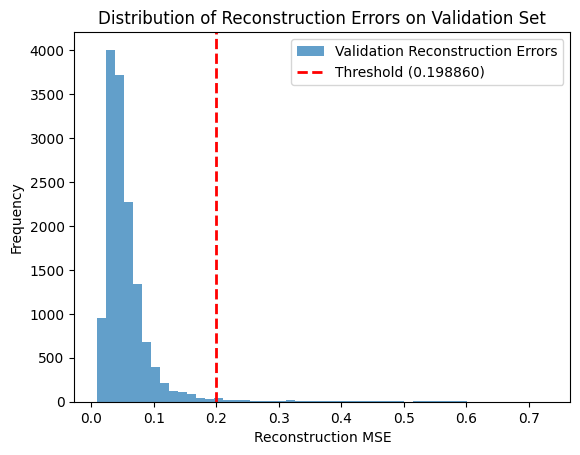


결정된 재구성 오차 임계값: 0.198860


In [ ]:
val_reconstruction_errors = []
loaded_model.eval() # 평가 모드
with torch.no_grad(): # 그래디언트 계산 비활성화
    for sequences in val_loader: # val_loader는 정규화된 데이터를 로드해야 함
        sequences = sequences.to(device)
        reconstructed = loaded_model(sequences)
        # 각 시퀀스 샘플별 MSE 계산
        # (batch, time_steps, features) -> (batch, time_steps * features)
        # 이후 각 샘플별로 평균 제곱 오차 계산
        mse = torch.mean((sequences - reconstructed)**2, dim=[1, 2]) # 각 윈도우(샘플)별 MSE
        val_reconstruction_errors.extend(mse.cpu().numpy())

val_reconstruction_errors = np.array(val_reconstruction_errors)

if len(val_reconstruction_errors) > 0:
    # 재구성 오차 분포 확인 (예: 히스토그램, 기술 통계)
    import matplotlib.pyplot as plt
    plt.hist(val_reconstruction_errors, bins=50, alpha=0.7, label='Validation Reconstruction Errors')
    plt.xlabel("Reconstruction MSE")
    plt.ylabel("Frequency")
    plt.title("Distribution of Reconstruction Errors on Validation Set")
    
    # 임계값 결정 (예: 95 백분위수 또는 특정 값)
    # 이 값은 실험을 통해 조절해야 합니다.
    THRESHOLD = np.percentile(val_reconstruction_errors, 98) # 예: 상위 5%를 이상치로 간주
    # 또는 THRESHOLD = np.mean(val_reconstruction_errors) + 2 * np.std(val_reconstruction_errors)
    
    plt.axvline(THRESHOLD, color='r', linestyle='dashed', linewidth=2, label=f'Threshold ({THRESHOLD:.6f})')
    plt.legend()
    plt.show() # Colab이나 Jupyter Notebook 환경에서는 plt.show()가 그래프를 표시
    print(f"\n결정된 재구성 오차 임계값: {THRESHOLD:.6f}")
else:
    print("검증 데이터에 대한 재구성 오차를 계산할 수 없습니다. 임계값 설정이 불가능합니다.")
    THRESHOLD = float('inf') # 임시 임계값

In [ ]:
def detect_anomalies_in_video(video_path, model, scaler, threshold,
                               time_steps, stride, feature_extraction_fn, device):
    model.eval()
    all_windows_in_video = []
    anomalous_window_indices = [] # 이상치로 판단된 윈도우의 인덱스 저장

    try:
        landmarks_video = np.load(video_path)
        if landmarks_video.ndim != 3 or landmarks_video.shape[1] != 12 or landmarks_video.shape[2] != 3:
            print(f"오류: {video_path} 파일 형태가 올바르지 않습니다.")
            return [], [] # 빈 리스트 반환

        derived_features_video = []
        for frame_idx in range(landmarks_video.shape[0]):
            landmarks_frame = landmarks_video[frame_idx, :, :]
            derived_features = feature_extraction_fn(landmarks_frame)
            derived_features_video.append(derived_features)
        derived_features_video = np.array(derived_features_video)

        # 슬라이딩 윈도우 생성
        for i in range(0, derived_features_video.shape[0] - time_steps + 1, stride):
            sequence = derived_features_video[i : i + time_steps]
            all_windows_in_video.append(sequence)
        
        if not all_windows_in_video:
            print(f"{video_path}에서 윈도우를 생성할 수 없습니다.")
            return [], []

        all_windows_np = np.array(all_windows_in_video, dtype=np.float32)

        # NaN 포함 윈도우 처리 (여기서는 그냥 해당 윈도우는 정상으로 간주하거나, NaN으로 표시)
        # 또는 학습 데이터처럼 제거할 수도 있지만, 예측 시에는 모든 윈도우에 대한 판단이 필요할 수 있음
        window_errors = []
        original_indices = [] # NaN이 아닌 윈도우의 원본 인덱스

        for idx, window in enumerate(all_windows_np):
            if np.isnan(window).any():
                window_errors.append(0) # NaN 포함 윈도우는 오차 0 (정상)으로 간주하거나 다른 처리
                # 또는 window_errors.append(np.nan) 등으로 표시
                continue
            
            original_indices.append(idx) # NaN이 아닌 윈도우의 인덱스 저장
            # 정규화 (학습 시 사용한 scaler와 동일하게)
            # scaler는 2D 입력을 기대하므로 reshape
            window_reshaped = window.reshape(-1, window.shape[-1])
            window_scaled_reshaped = scaler.transform(window_reshaped)
            window_scaled = window_scaled_reshaped.reshape(window.shape)
            
            window_tensor = torch.tensor(window_scaled, dtype=torch.float32).unsqueeze(0).to(device) # 배치 차원 추가

            with torch.no_grad():
                reconstructed = model(window_tensor)
                mse = torch.mean((window_tensor - reconstructed)**2).item() # 단일 윈도우에 대한 MSE
            window_errors.append(mse)

        window_errors_np = np.array(window_errors)
        
        # NaN이 아닌 윈도우들에 대해서만 이상치 판단
        # (만약 NaN 윈도우를 다른 값으로 채웠다면, 모든 window_errors_np에 대해 판단)
        for i, original_idx in enumerate(original_indices):
            if window_errors_np[original_idx] > threshold : # NaN 윈도우는 이 조건문에 들어오지 않음
                 anomalous_window_indices.append(original_idx)
        
        return window_errors_np, anomalous_window_indices

    except FileNotFoundError:
        print(f"오류: 파일을 찾을 수 없습니다 -> {video_path}")
        return [], []
    except Exception as e:
        print(f"'{video_path}' 처리 중 오류: {e}")
        return [], []

# --- 이상치 탐지 실행 예시 ---
# 새로운 비디오 파일 경로 (테스트용)
# 실제로는 사용자가 업로드하거나 실시간 스트리밍으로부터 .npy 형태로 변환된 데이터를 가정
new_video_npy_path = './../data/mediapipe_res/good_test/clean_squat_squat_000013_res.npy' # 예시 경로


if 'loaded_model' in globals() and 'scaler' in globals() and THRESHOLD != float('inf'):
    print(f"\n--- 새로운 비디오({new_video_npy_path})에 대한 이상치 탐지 ---")
    # 더미 파일 생성 (테스트용)
    if not os.path.exists(new_video_npy_path):
        print(f"경고: 테스트 파일({new_video_npy_path})이 없습니다. 더미 데이터를 생성합니다.")
        dummy_new_data = np.random.rand(300, 12, 3).astype(np.float32) # (프레임, 12랜드마크, 3좌표)
        # 디렉토리 확인 및 생성
        os.makedirs(os.path.dirname(new_video_npy_path), exist_ok=True)
        np.save(new_video_npy_path, dummy_new_data)

    errors, anomalies = detect_anomalies_in_video(
        new_video_npy_path,
        loaded_model,
        scaler, # 학습 시 사용한 scaler
        THRESHOLD,
        TIME_STEPS,
        WINDOW_STRIDE,
        extract_derived_features, # 사용자 정의 함수
        device
    )

    if anomalies:
        print(f"총 {len(errors)}개의 윈도우 중 {len(anomalies)}개의 이상치 윈도우 감지:")
        print("이상치 윈도우 인덱스:", anomalies)
        # print("각 윈도우별 재구성 오차:", errors) # 모든 윈도우 오차 확인
    elif errors.size > 0 : # errors가 비어있지 않고 anomalies가 비어있다면
        print(f"총 {len(errors)}개의 윈도우 분석 완료. 이상치 감지되지 않음.")
        # print("각 윈도우별 재구성 오차:", errors)
    else:
        print(f"{new_video_npy_path} 분석 중 문제가 발생했거나 윈도우가 생성되지 않았습니다.")

else:
    if THRESHOLD == float('inf'):
        print("\n임계값이 제대로 설정되지 않아 이상치 탐지를 실행할 수 없습니다.")
    else:
        print("\n모델 또는 스케일러가 로드되지 않아 이상치 탐지를 실행할 수 없습니다.")


--- 새로운 비디오(/data/hamboong/tmp/cap/data/mediapipe_res/good_test/clean_squat_squat_000013_res.npy)에 대한 이상치 탐지 ---
총 271개의 윈도우 분석 완료. 이상치 감지되지 않음.


In [ ]:
import torch
import torch.nn as nn
# import torch.optim as optim # 평가 시에는 필요 없음
# from torch.utils.data import Dataset, DataLoader, random_split # 평가 시에는 필요 없음
import numpy as np
import os
import glob
# from sklearn.preprocessing import StandardScaler # scaler는 이미 학습/로드 되었다고 가정
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score # 추가
# import matplotlib.pyplot as plt # 여기서는 직접 사용하지 않음

def evaluate_model_performance(data_dir, true_label, model, scaler, threshold,
                               time_steps, stride, feature_extraction_fn, device):
    """지정된 디렉토리의 모든 .npy 파일에 대해 이상치 탐지를 수행하고 예측 결과를 반환합니다."""
    y_true = []
    y_pred = []
    
    npy_files = glob.glob(os.path.join(data_dir, "*.npy"))
    if not npy_files:
        print(f"경고: {data_dir} 에서 평가할 .npy 파일을 찾을 수 없습니다.")
        return y_true, y_pred

    print(f"\n--- '{os.path.basename(data_dir)}' 폴더 평가 시작 ({len(npy_files)}개 파일) ---")
    for npy_file in npy_files:
        # print(f"파일 평가 중: {os.path.basename(npy_file)}")
        
        # detect_anomalies_in_video 함수는 여기서 정의되어야 합니다.
        # 이전 답변에 있는 함수를 사용한다고 가정합니다.
        # 여기서는 함수의 핵심 로직을 간략히 다시 구현하거나, 해당 함수를 호출합니다.
        
        # ---- detect_anomalies_in_video 내부 로직 간소화 버전 (실제로는 함수 호출) ----
        processed_correctly = True
        anomalies_found_in_video = False
        try:
            landmarks_video = np.load(npy_file)
            if landmarks_video.ndim != 3 or landmarks_video.shape[1] != 12 or landmarks_video.shape[2] != 3:
                print(f"  경고: {os.path.basename(npy_file)} 파일 형태가 올바르지 않음. 건너뜀.")
                processed_correctly = False
            
            if processed_correctly:
                derived_features_video = np.array([feature_extraction_fn(landmarks_video[i]) for i in range(landmarks_video.shape[0])])
                
                current_video_windows = []
                for i in range(0, derived_features_video.shape[0] - time_steps + 1, stride):
                    sequence = derived_features_video[i : i + time_steps]
                    current_video_windows.append(sequence)
                
                if not current_video_windows:
                    processed_correctly = False
                
                if processed_correctly:
                    current_video_windows_np = np.array(current_video_windows, dtype=np.float32)
                    nan_mask = ~np.isnan(current_video_windows_np).any(axis=(1,2))
                    valid_windows = current_video_windows_np[nan_mask]

                    if valid_windows.shape[0] == 0:
                        processed_correctly = False # 유효한 윈도우 없음
                    
                    if processed_correctly:
                        # 정규화
                        valid_windows_reshaped = valid_windows.reshape(-1, valid_windows.shape[-1])
                        valid_windows_scaled_reshaped = scaler.transform(valid_windows_reshaped)
                        valid_windows_scaled = valid_windows_scaled_reshaped.reshape(valid_windows.shape)
                        
                        windows_tensor = torch.tensor(valid_windows_scaled, dtype=torch.float32).to(device)
                        
                        model.eval()
                        with torch.no_grad():
                            reconstructed = model(windows_tensor)
                            mse_per_window = torch.mean((windows_tensor - reconstructed)**2, dim=[1,2]).cpu().numpy()
                        
                        if np.any(mse_per_window > threshold):
                            anomalies_found_in_video = True
        except Exception as e:
            print(f"  오류: {os.path.basename(npy_file)} 처리 중 문제 발생 - {e}")
            processed_correctly = False
        # ---- detect_anomalies_in_video 내부 로직 간소화 버전 끝 ----

        if processed_correctly:
            y_true.append(true_label)
            y_pred.append(1 if anomalies_found_in_video else 0)
            # print(f"  결과: {'이상치 감지됨' if anomalies_found_in_video else '이상치 없음'}")
        else:
            # 파일 처리 실패 시 해당 샘플은 평가에서 제외하거나, 별도 처리
            print(f"  {os.path.basename(npy_file)} 파일 처리에 실패하여 평가에서 제외될 수 있습니다.")
            
    return y_true, y_pred


# --- 스크립트 실행 부분 ---
if __name__ == '__main__':

    DATA_DIR_GOOD = "./../data/mediapipe_res/good" # 학습에 사용된 좋은 자세 데이터 경로
    BAD_VIDEO_DIR = "./../data/mediapipe_res/bad_innner_thigh" # 테스트할 나쁜 자세 데이터 경로

    # "좋은 자세" 데이터 평가 (실제 레이블: 0)
    y_true_good, y_pred_good = evaluate_model_performance(
        DATA_DIR_GOOD, 0, loaded_model, scaler, THRESHOLD,
        TIME_STEPS, WINDOW_STRIDE, extract_derived_features, device
    )

    # "나쁜 자세" 데이터 평가 (실제 레이블: 1)
    y_true_bad, y_pred_bad = evaluate_model_performance(
        BAD_VIDEO_DIR, 1, loaded_model, scaler, THRESHOLD,
        TIME_STEPS, WINDOW_STRIDE, extract_derived_features, device
    )

    # 전체 결과 취합
    y_true_combined = np.array(y_true_good + y_true_bad)
    y_pred_combined = np.array(y_pred_good + y_pred_bad)

    if len(y_true_combined) > 0 and len(y_true_combined) == len(y_pred_combined):
        accuracy = accuracy_score(y_true_combined, y_pred_combined)
        # 'bad' 클래스(레이블 1)에 대한 재현율
        recall_bad_class = recall_score(y_true_combined, y_pred_combined, pos_label=1, zero_division=0)
        # 'good' 클래스(레이블 0)에 대한 재현율 (Specificity와 유사)
        # recall_good_class = recall_score(y_true_combined, y_pred_combined, pos_label=0, zero_division=0)


        print("\n\n--- 최종 평가 결과 ---")
        print(f"전체 정확도 (Overall Accuracy): {accuracy:.4f}")
        print(f"'나쁜 자세'에 대한 재현율 (Recall for 'bad' class): {recall_bad_class:.4f}")
        # print(f"'좋은 자세'에 대한 재현율 (Recall for 'good' class / Specificity): {recall_good_class:.4f}")
        
        print("\n--- Classification Report (Combined) ---")
        # target_names는 레이블 순서에 맞게 [0, 1] -> ['good_pose', 'bad_pose']
        print(classification_report(y_true_combined, y_pred_combined, target_names=['good_pose', 'bad_pose'], zero_division=0))

        print("\n--- Confusion Matrix (Combined) ---")
        # 레이블: [0 (Good), 1 (Bad)]
        #       Predicted Good | Predicted Bad
        # True Good TN         | FP
        # True Bad  FN         | TP
        cm = confusion_matrix(y_true_combined, y_pred_combined, labels=[0,1])
        print("레이블: [0 (Good), 1 (Bad)]")
        print(cm)

    else:
        print("\n평가할 데이터가 충분하지 않거나, 결과 취합에 문제가 있습니다.")

    print("\n전체 스크립트 실행 완료.")


--- 'good' 폴더 평가 시작 (268개 파일) ---

--- 'bad_innner_thigh' 폴더 평가 시작 (34개 파일) ---


--- 최종 평가 결과 ---
전체 정확도 (Overall Accuracy): 0.8841
'나쁜 자세'에 대한 재현율 (Recall for 'bad' class): 0.8529

--- Classification Report (Combined) ---
              precision    recall  f1-score   support

   good_pose       0.98      0.89      0.93       268
    bad_pose       0.49      0.85      0.62        34

    accuracy                           0.88       302
   macro avg       0.74      0.87      0.78       302
weighted avg       0.92      0.88      0.90       302


--- Confusion Matrix (Combined) ---
레이블: [0 (Good), 1 (Bad)]
[[238  30]
 [  5  29]]

전체 스크립트 실행 완료.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import os
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # 추가
import matplotlib.pyplot as plt # THRESHOLD 시각화용


# --- 1. 하이퍼파라미터 및 설정 (이전 코드와 동일) ---
DATA_DIR_GOOD = "./../data/mediapipe_res/good" # 학습에 사용된 좋은 자세 데이터 경로
BAD_VIDEO_DIR = "./../data/mediapipe_res/bad_innner_thigh" # 테스트할 나쁜 자세 데이터 경로

# --- 5. "bad_innner_thigh" 폴더 내 파일들에 대한 평가 ---
print(f"\n--- '{BAD_VIDEO_DIR}' 폴더 내 파일들에 대한 이상치 평가 ---")
bad_npy_files = glob.glob(os.path.join(BAD_VIDEO_DIR, "*.npy"))

if not bad_npy_files:
    print(f"경고: {BAD_VIDEO_DIR} 에서 평가할 .npy 파일을 찾을 수 없습니다.")
else:
    y_true_bad_videos = [] # 실제로는 모두 'bad' (1)
    y_pred_bad_videos = [] # 모델 예측: 'bad' (1) or 'not_bad' (0)

    for npy_file in bad_npy_files:
        print(f"파일 평가 중: {os.path.basename(npy_file)}")
        # 이 폴더의 모든 영상은 "나쁜 자세" (True Label = 1)라고 가정
        y_true_bad_videos.append(1)

        errors, anomalies = detect_anomalies_in_video(
            npy_file,
            loaded_model,
            scaler,
            THRESHOLD,
            TIME_STEPS,
            WINDOW_STRIDE,
            extract_derived_features,
            device
        )

        if len(anomalies) > 0: # 하나 이상의 윈도우라도 이상치로 감지되면 해당 영상은 "bad"로 예측
            y_pred_bad_videos.append(1)
            print(f"  결과: 이상치 감지됨 (총 {len(errors)}개 윈도우 중 {len(anomalies)}개)")
        elif errors.size > 0 : # 오류 없이 분석 완료되었으나 이상치 없음
            y_pred_bad_videos.append(0)
            print(f"  결과: 이상치 감지되지 않음 (총 {len(errors)}개 윈도우 분석)")
        else: # 파일 처리 중 문제 발생 (예: 파일 못읽음, 윈도우 생성 안됨)
            # 이런 경우는 평가에서 제외하거나, 특정 값으로 처리해야 함
            # 여기서는 예측 실패로 간주하고, 실제 값과 다른 값으로 예측했다고 가정 (예: 0)
            # 또는 y_true_bad_videos에서도 해당 샘플을 제거해야 함
            print(f"  결과: 파일 처리 오류 또는 유효 윈도우 없음. 평가에서 제외될 수 있음.")
            # y_true_bad_videos.pop() # 만약 해당 샘플을 평가에서 제외하려면

    if y_true_bad_videos and y_pred_bad_videos and len(y_true_bad_videos) == len(y_pred_bad_videos):
        print("\n--- Classification Report (Bad Videos) ---")
        # 레이블 0: "not_bad" (모델이 나쁜 자세를 나쁘다고 판단 못한 경우)
        # 레이블 1: "bad" (모델이 나쁜 자세를 나쁘다고 판단한 경우)
        target_names = ['predicted_not_bad', 'predicted_bad']
        print(classification_report(y_true_bad_videos, y_pred_bad_videos, target_names=target_names, zero_division=0))
        
        print("\n--- Confusion Matrix (Bad Videos) ---")
        # 행: 실제 클래스, 열: 예측 클래스
        # 이 경우 실제는 모두 'bad'(1)이므로, Confusion Matrix의 첫번째 행은 모두 0이어야 함.
        # [[TN, FP],
        #  [FN, TP]]
        # 여기서는 True Negative (TN)와 False Positive (FP)는 나올 수 없음 (y_true가 항상 1이므로)
        # 결과적으로는 [[0, 0], [FN, TP]] 형태가 됨
        cm = confusion_matrix(y_true_bad_videos, y_pred_bad_videos, labels=[0,1])
        print("레이블: [0 (Not Bad), 1 (Bad)]")
        print(cm)
        
        accuracy = accuracy_score(y_true_bad_videos, y_pred_bad_videos)
        print(f"\n정확도 (Accuracy on these 'bad' videos): {accuracy:.4f}")
        if len(y_true_bad_videos) > 0:
            recall_bad = cm[1,1] / (cm[1,0] + cm[1,1]) if (cm[1,0] + cm[1,1]) > 0 else 0
            print(f"나쁜 자세 재현율 (Recall for 'bad' class): {recall_bad:.4f} (얼마나 많은 실제 '나쁜 자세' 영상을 '나쁘다'고 잡아냈는가)")

    else:
        print("평가할 데이터가 충분하지 않거나, 실제/예측 레이블 개수가 맞지 않습니다.")

print("\n전체 스크립트 실행 완료.")


--- '/data/hamboong/tmp/cap/data/mediapipe_res/bad_innner_thigh' 폴더 내 파일들에 대한 이상치 평가 ---
파일 평가 중: 0918_squat_000029_res.npy
  결과: 이상치 감지됨 (총 271개 윈도우 중 170개)
파일 평가 중: 0918_squat_000030_res.npy
  결과: 이상치 감지됨 (총 271개 윈도우 중 119개)
파일 평가 중: 0918_squat_000032_res.npy
  결과: 이상치 감지됨 (총 271개 윈도우 중 136개)
파일 평가 중: 0918_squat_000033_res.npy
  결과: 이상치 감지됨 (총 271개 윈도우 중 219개)
파일 평가 중: 0918_squat_000036_res.npy
  결과: 이상치 감지됨 (총 271개 윈도우 중 111개)
파일 평가 중: 0918_squat_000066_res.npy
  결과: 이상치 감지됨 (총 271개 윈도우 중 177개)
파일 평가 중: 0918_squat_000069_res.npy
  결과: 이상치 감지됨 (총 271개 윈도우 중 146개)
파일 평가 중: 0918_squat_000070_res.npy
  결과: 이상치 감지됨 (총 271개 윈도우 중 206개)
파일 평가 중: 0918_squat_000073_res.npy
  결과: 이상치 감지됨 (총 271개 윈도우 중 168개)
파일 평가 중: 0922_squat_000040_res.npy
  결과: 이상치 감지됨 (총 271개 윈도우 중 137개)
파일 평가 중: 0922_squat_000041_res.npy
  결과: 이상치 감지됨 (총 271개 윈도우 중 42개)
파일 평가 중: 0922_squat_000043_res.npy
  결과: 이상치 감지됨 (총 271개 윈도우 중 109개)
파일 평가 중: 0922_squat_000044_res.npy
  결과: 이상치 감지됨 (총 271개 윈도우 중 232개)
파일 평가 중: 0922_

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
# import torch.optim as optim # 평가 시에는 필요 없음
# from torch.utils.data import Dataset, DataLoader, random_split # 평가 시에는 필요 없음
import numpy as np
import os
import glob
# from sklearn.preprocessing import StandardScaler # scaler는 이미 학습/로드 되었다고 가정
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score # 추가
# import matplotlib.pyplot as plt # 여기서는 직접 사용하지 않음

def evaluate_model_performance(data_dir, true_label, model, scaler, threshold,
                               time_steps, stride, feature_extraction_fn, device):
    """지정된 디렉토리의 모든 .npy 파일에 대해 이상치 탐지를 수행하고 예측 결과를 반환합니다."""
    y_true = []
    y_pred = []
    
    npy_files = glob.glob(os.path.join(data_dir, "*.npy"))
    if not npy_files:
        print(f"경고: {data_dir} 에서 평가할 .npy 파일을 찾을 수 없습니다.")
        return y_true, y_pred

    print(f"\n--- '{os.path.basename(data_dir)}' 폴더 평가 시작 ({len(npy_files)}개 파일) ---")
    for npy_file in npy_files:
        # print(f"파일 평가 중: {os.path.basename(npy_file)}")
        
        # detect_anomalies_in_video 함수는 여기서 정의되어야 합니다.
        # 이전 답변에 있는 함수를 사용한다고 가정합니다.
        # 여기서는 함수의 핵심 로직을 간략히 다시 구현하거나, 해당 함수를 호출합니다.
        
        # ---- detect_anomalies_in_video 내부 로직 간소화 버전 (실제로는 함수 호출) ----
        processed_correctly = True
        anomalies_found_in_video = False
        try:
            landmarks_video = np.load(npy_file)
            if landmarks_video.ndim != 3 or landmarks_video.shape[1] != 12 or landmarks_video.shape[2] != 3:
                print(f"  경고: {os.path.basename(npy_file)} 파일 형태가 올바르지 않음. 건너뜀.")
                processed_correctly = False
            
            if processed_correctly:
                derived_features_video = np.array([feature_extraction_fn(landmarks_video[i]) for i in range(landmarks_video.shape[0])])
                
                current_video_windows = []
                for i in range(0, derived_features_video.shape[0] - time_steps + 1, stride):
                    sequence = derived_features_video[i : i + time_steps]
                    current_video_windows.append(sequence)
                
                if not current_video_windows:
                    processed_correctly = False
                
                if processed_correctly:
                    current_video_windows_np = np.array(current_video_windows, dtype=np.float32)
                    nan_mask = ~np.isnan(current_video_windows_np).any(axis=(1,2))
                    valid_windows = current_video_windows_np[nan_mask]

                    if valid_windows.shape[0] == 0:
                        processed_correctly = False # 유효한 윈도우 없음
                    
                    if processed_correctly:
                        # 정규화
                        valid_windows_reshaped = valid_windows.reshape(-1, valid_windows.shape[-1])
                        valid_windows_scaled_reshaped = scaler.transform(valid_windows_reshaped)
                        valid_windows_scaled = valid_windows_scaled_reshaped.reshape(valid_windows.shape)
                        
                        windows_tensor = torch.tensor(valid_windows_scaled, dtype=torch.float32).to(device)
                        
                        model.eval()
                        with torch.no_grad():
                            reconstructed = model(windows_tensor)
                            mse_per_window = torch.mean((windows_tensor - reconstructed)**2, dim=[1,2]).cpu().numpy()
                        
                        if np.any(mse_per_window > threshold):
                            anomalies_found_in_video = True
        except Exception as e:
            print(f"  오류: {os.path.basename(npy_file)} 처리 중 문제 발생 - {e}")
            processed_correctly = False
        # ---- detect_anomalies_in_video 내부 로직 간소화 버전 끝 ----

        if processed_correctly:
            y_true.append(true_label)
            y_pred.append(1 if anomalies_found_in_video else 0)
            # print(f"  결과: {'이상치 감지됨' if anomalies_found_in_video else '이상치 없음'}")
        else:
            # 파일 처리 실패 시 해당 샘플은 평가에서 제외하거나, 별도 처리
            print(f"  {os.path.basename(npy_file)} 파일 처리에 실패하여 평가에서 제외될 수 있습니다.")
            
    return y_true, y_pred


# --- 스크립트 실행 부분 ---
if __name__ == '__main__':

    DATA_DIR_GOOD = "./../data/mediapipe_res/good_test" # 학습에 사용된 좋은 자세 데이터 경로
    BAD_VIDEO_DIR = "./../data/mediapipe_res/bad_innner_thigh" # 테스트할 나쁜 자세 데이터 경로

    # "좋은 자세" 데이터 평가 (실제 레이블: 0)
    y_true_good, y_pred_good = evaluate_model_performance(
        DATA_DIR_GOOD, 0, loaded_model, scaler, THRESHOLD,
        TIME_STEPS, WINDOW_STRIDE, extract_derived_features, device
    )

    # "나쁜 자세" 데이터 평가 (실제 레이블: 1)
    y_true_bad, y_pred_bad = evaluate_model_performance(
        BAD_VIDEO_DIR, 1, loaded_model, scaler, THRESHOLD,
        TIME_STEPS, WINDOW_STRIDE, extract_derived_features, device
    )

    # 전체 결과 취합
    y_true_combined = np.array(y_true_good + y_true_bad)
    y_pred_combined = np.array(y_pred_good + y_pred_bad)

    if len(y_true_combined) > 0 and len(y_true_combined) == len(y_pred_combined):
        accuracy = accuracy_score(y_true_combined, y_pred_combined)
        # 'bad' 클래스(레이블 1)에 대한 재현율
        recall_bad_class = recall_score(y_true_combined, y_pred_combined, pos_label=1, zero_division=0)
        # 'good' 클래스(레이블 0)에 대한 재현율 (Specificity와 유사)
        # recall_good_class = recall_score(y_true_combined, y_pred_combined, pos_label=0, zero_division=0)


        print("\n\n--- 최종 평가 결과 ---")
        print(f"전체 정확도 (Overall Accuracy): {accuracy:.4f}")
        print(f"'나쁜 자세'에 대한 재현율 (Recall for 'bad' class): {recall_bad_class:.4f}")
        # print(f"'좋은 자세'에 대한 재현율 (Recall for 'good' class / Specificity): {recall_good_class:.4f}")
        
        print("\n--- Classification Report (Combined) ---")
        # target_names는 레이블 순서에 맞게 [0, 1] -> ['good_pose', 'bad_pose']
        print(classification_report(y_true_combined, y_pred_combined, target_names=['good_pose', 'bad_pose'], zero_division=0))

        print("\n--- Confusion Matrix (Combined) ---")
        # 레이블: [0 (Good), 1 (Bad)]
        #       Predicted Good | Predicted Bad
        # True Good TN         | FP
        # True Bad  FN         | TP
        cm = confusion_matrix(y_true_combined, y_pred_combined, labels=[0,1])
        print("레이블: [0 (Good), 1 (Bad)]")
        print(cm)

    else:
        print("\n평가할 데이터가 충분하지 않거나, 결과 취합에 문제가 있습니다.")

    print("\n전체 스크립트 실행 완료.")


--- 'good_test' 폴더 평가 시작 (33개 파일) ---

--- 'bad_innner_thigh' 폴더 평가 시작 (34개 파일) ---


--- 최종 평가 결과 ---
전체 정확도 (Overall Accuracy): 0.5224
'나쁜 자세'에 대한 재현율 (Recall for 'bad' class): 0.7059

--- Classification Report (Combined) ---
              precision    recall  f1-score   support

   good_pose       0.52      0.33      0.41        33
    bad_pose       0.52      0.71      0.60        34

    accuracy                           0.52        67
   macro avg       0.52      0.52      0.50        67
weighted avg       0.52      0.52      0.51        67


--- Confusion Matrix (Combined) ---
레이블: [0 (Good), 1 (Bad)]
[[11 22]
 [10 24]]

전체 스크립트 실행 완료.
